# Experimental Validation: On Emergence of Clean-Priority Learning in Early Stopped Neural Networks

This notebook aims to experimentally validate the key findings presented in the paper "On Emergence of Clean-Priority Learning in Early Stopped Neural Networks" (Liu, Abedsoltan, Belkin, 2023, arXiv:2306.02533).

**Key Phenomena to Investigate:**
1.  **Clean-Priority Learning:** Neural networks tend to learn patterns from clean data first before fitting to noisy labels.
2.  **U-Shaped Test Error:** The test error on a clean dataset initially decreases, reaches a minimum (early stopping point), and then increases as the network starts overfitting to noisy training labels.
3.  **Subset Dynamics:** Training error on the clean subset of training data decreases, while error on the noisy subset initially increases and then decreases.
4.  **Gradient Dominance:** The dominance of gradients from clean samples over noisy samples diminishes over training, leading to the termination of clean-priority learning.

We will use PyTorch for model implementation and training, and Matplotlib for visualizations.

## 1. Setup and Helper Functions

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import copy

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


### 1.1 Data Handling and Noise Injection

In [10]:
class NoisyDataset(Dataset):
    """Wrapper to add label noise to a dataset."""
    def __init__(self, dataset, noise_level=0.0, num_classes=10, random_seed=42):
        self.dataset = dataset
        self.noise_level = noise_level
        self.num_classes = num_classes
        self.original_labels = []
        self.noisy_labels = []
        self.is_noisy = [] # To track which samples had their labels flipped

        if not (0.0 <= noise_level <= 1.0):
            raise ValueError("Noise level must be between 0.0 and 1.0")

        np.random.seed(random_seed) # Ensure noise is consistent
        
        num_samples = len(self.dataset)
        num_noisy_samples = int(noise_level * num_samples)
        noisy_indices = np.random.choice(num_samples, size=num_noisy_samples, replace=False)

        for i in range(num_samples):
            image, original_label = self.dataset[i]
            self.original_labels.append(original_label)
            
            if i in noisy_indices:
                self.is_noisy.append(True)
                # Uniformly choose a different label
                possible_new_labels = [l for l in range(num_classes) if l != original_label]
                if not possible_new_labels: # Handle binary case where only one other label exists
                     noisy_label = (original_label + 1) % num_classes
                else:
                    noisy_label = np.random.choice(possible_new_labels)
                self.noisy_labels.append(noisy_label)
            else:
                self.is_noisy.append(False)
                self.noisy_labels.append(original_label)
                
        self.noisy_labels = torch.tensor(self.noisy_labels, dtype=torch.long)
        self.original_labels = torch.tensor(self.original_labels, dtype=torch.long)
        self.is_noisy = torch.tensor(self.is_noisy, dtype=torch.bool)

    def __getitem__(self, index):
        image, _ = self.dataset[index] # Original dataset might return original label
        noisy_label = self.noisy_labels[index]
        original_label = self.original_labels[index]
        is_noisy_sample = self.is_noisy[index]
        return image, noisy_label, original_label, is_noisy_sample, index

    def __len__(self):
        return len(self.dataset)

def get_mnist_datasets(binary_classes=None, data_dir='./data'):
    """Load MNIST dataset, optionally filtering for binary classification."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset_full = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_dataset_full = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

    if binary_classes:
        assert len(binary_classes) == 2, "binary_classes must contain two class labels"
        c1, c2 = binary_classes
        
        # Filter train set
        train_indices_c1 = [i for i, (_, label) in enumerate(train_dataset_full) if label == c1]
        train_indices_c2 = [i for i, (_, label) in enumerate(train_dataset_full) if label == c2]
        train_dataset_filtered = Subset(train_dataset_full, train_indices_c1 + train_indices_c2)
        # Remap labels to 0 and 1
        train_targets_filtered = torch.cat([torch.zeros(len(train_indices_c1), dtype=torch.long), 
                                          torch.ones(len(train_indices_c2), dtype=torch.long)])
        
        # Filter test set
        test_indices_c1 = [i for i, (_, label) in enumerate(test_dataset_full) if label == c1]
        test_indices_c2 = [i for i, (_, label) in enumerate(test_dataset_full) if label == c2]
        test_dataset_filtered = Subset(test_dataset_full, test_indices_c1 + test_indices_c2)
        test_targets_filtered = torch.cat([torch.zeros(len(test_indices_c1), dtype=torch.long), 
                                         torch.ones(len(test_indices_c2), dtype=torch.long)])
        
        # Create new datasets with remapped labels
        class RemappedDataset(Dataset):
            def __init__(self, subset_dataset, new_targets):
                self.subset_dataset = subset_dataset
                self.new_targets = new_targets
            def __getitem__(self, index):
                image, _ = self.subset_dataset[index]
                return image, self.new_targets[index]
            def __len__(self):
                return len(self.subset_dataset)

        train_dataset = RemappedDataset(train_dataset_filtered, train_targets_filtered)
        test_dataset = RemappedDataset(test_dataset_filtered, test_targets_filtered)
        num_classes = 2 # This indicates the number of distinct classes in the dataset
    else:
        train_dataset = train_dataset_full
        test_dataset = test_dataset_full
        num_classes = 10
        
    return train_dataset, test_dataset, num_classes

def get_cifar10_datasets(data_dir='./data'):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)
    return train_dataset, test_dataset, 10

### 1.2 Model Definitions

In [11]:
class FCN(nn.Module):
    """Fully Connected Network for MNIST (binary or multi-class)."""
    def __init__(self, input_dim=28*28, hidden_dims=[512, 512], num_classes=10):
        super(FCN, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten
        return self.network(x)

class CNN_MNIST(nn.Module):
    """CNN for MNIST as described in paper's appendix (Fig 7, 10)."""
    # Based on: two conv layers (32, 64 channels, 3x3 kernel, stride 1), 
    # one max pooling, two FC layers (64, 10).
    def __init__(self, num_classes=10):
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # MNIST images are 28x28. After one 2x2 pooling, they become 14x14.
        self.fc1 = nn.Linear(64 * 14 * 14, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# BasicBlock and ResNet for CIFAR-10 (ResNet-9 like structure)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet9_CIFAR(nn.Module):
    # A common ResNet-9 structure for CIFAR-10
    def __init__(self, num_blocks=[1,1,1,1], num_classes=10):
        super(ResNet9_CIFAR, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, num_blocks[0], stride_val=1)
        self.layer2 = self._make_layer(BasicBlock, 128, num_blocks[1], stride_val=2)
        self.layer3 = self._make_layer(BasicBlock, 256, num_blocks[2], stride_val=2)
        self.linear = nn.Linear(256*BasicBlock.expansion, num_classes)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))

    def _make_layer(self, block, planes, num_blocks, stride_val):
        strides = [stride_val] + [1]*(num_blocks-1)
        layers = []
        for current_stride in strides: 
            layers.append(block(self.in_planes, planes, current_stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x))) 
        x = self.layer1(x) 
        x = self.layer2(x) 
        x = self.layer3(x) 
        x = self.adaptive_pool(x) 
        x = x.view(x.size(0), -1) 
        x = self.linear(x)
        return x

class ResNet9_CIFAR_Simple(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        
        self.prep_layer = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer1_conv = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.layer1_pool = nn.MaxPool2d(2, 2) # 32x32 -> 16x16
        self.layer1_bn = nn.BatchNorm2d(128)
        self.layer1_relu = nn.ReLU()
        
        self.res1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer2_conv = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
        self.layer2_pool = nn.MaxPool2d(2, 2) # 16x16 -> 8x8
        self.layer2_bn = nn.BatchNorm2d(256)
        self.layer2_relu = nn.ReLU()
        
        self.res2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(2,2) # 8x8 -> 4x4 
        self.classifier = nn.Linear(256 * 4 * 4, num_classes) 

    def forward(self, x):
        x = self.prep_layer(x)
        
        x = self.layer1_conv(x)
        x = self.layer1_pool(x)
        x = self.layer1_relu(self.layer1_bn(x))
        
        x = self.res1(x) + x # Residual connection 1
        
        x = self.layer2_conv(x)
        x = self.layer2_pool(x)
        x = self.layer2_relu(self.layer2_bn(x))
        
        x = self.res2(x) + x # Residual connection 2
        
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### 1.3 Training and Evaluation Utilities

In [12]:
def calculate_loss_and_accuracy(model, dataloader, criterion, device, is_noisy_dataset=False, store_sample_losses=False, num_classes_in_dataset=10):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_samples = 0
    
    clean_loss_sum = 0; noisy_loss_sum = 0
    clean_correct = 0; noisy_correct = 0
    num_clean_samples = 0; num_noisy_samples = 0
    clean_residual_sum = 0; noisy_residual_sum = 0

    all_sample_indices = []
    all_sample_is_noisy_flags = []
    all_sample_original_labels = []
    all_sample_losses_values = []

    with torch.no_grad():
        for batch_data in dataloader: 
            if is_noisy_dataset:
                images, noisy_labels, original_labels, is_noisy_flags, sample_indices = batch_data
                targets_for_loss = noisy_labels 
                targets_for_accuracy = noisy_labels
            else: 
                images, original_labels = batch_data
                targets_for_loss = original_labels
                targets_for_accuracy = original_labels
                is_noisy_flags = torch.zeros_like(original_labels, dtype=torch.bool)
                current_batch_size = images.size(0)
                sample_indices = torch.arange(total_samples, total_samples + current_batch_size, device=device if images.is_cuda else 'cpu')

            images = images.to(device)
            targets_for_loss = targets_for_loss.to(device)
            targets_for_accuracy = targets_for_accuracy.to(device) # For direct comparison with predicted class index
            original_labels = original_labels.to(device)
            is_noisy_flags = is_noisy_flags.to(device)
            sample_indices = sample_indices.to(device)

            outputs = model(images) # Model output, e.g., logits

            # Prepare targets for loss function based on criterion type
            current_targets_for_loss_fn = targets_for_loss
            is_binary_bce_case = isinstance(criterion, nn.BCEWithLogitsLoss) and outputs.shape[-1] == 1
            if is_binary_bce_case:
                current_targets_for_loss_fn = targets_for_loss.float().unsqueeze(1)
            
            # Calculate loss per sample
            loss_per_sample_raw = torch.zeros(images.size(0), device=device) # Default initialization
            if hasattr(criterion, 'reduction'):
                original_reduction = criterion.reduction
                criterion.reduction = 'none' 
                loss_per_sample_raw = criterion(outputs, current_targets_for_loss_fn)
                criterion.reduction = original_reduction 
            else:
                 loss_per_sample_raw = criterion(outputs, current_targets_for_loss_fn) 
            
            # Ensure loss_per_sample_val is 1D for .extend() to work correctly with scalars
            if loss_per_sample_raw.ndim > 1 and loss_per_sample_raw.shape[-1] == 1: # Handles [B, 1] case from BCEWithLogitsLoss
                loss_per_sample_val = loss_per_sample_raw.squeeze(-1)
            elif loss_per_sample_raw.ndim == 0: # Scalar loss returned unexpectedly
                loss_per_sample_val = loss_per_sample_raw.repeat(images.size(0)) # Replicate for batch
            else: # Should already be 1D [B] (e.g. from CrossEntropyLoss with reduction='none')
                loss_per_sample_val = loss_per_sample_raw
            
            loss = loss_per_sample_val.mean()
            total_loss += loss.item() * images.size(0)

            # Determine predicted classes for accuracy calculation
            if is_binary_bce_case:
                predicted = (outputs.data > 0.0).long().squeeze(1) 
            else: 
                _, predicted = torch.max(outputs.data, 1)
            
            total_samples += images.size(0)
            correct_preds += (predicted == targets_for_accuracy).sum().item()

            if store_sample_losses:
                all_sample_indices.extend(sample_indices.cpu().tolist())
                all_sample_is_noisy_flags.extend(is_noisy_flags.cpu().tolist())
                all_sample_original_labels.extend(original_labels.cpu().tolist())
                all_sample_losses_values.extend(loss_per_sample_val.cpu().tolist()) # loss_per_sample_val is now 1D

            if is_noisy_dataset:
                clean_mask = ~is_noisy_flags
                noisy_mask = is_noisy_flags

                if clean_mask.any():
                    clean_loss_sum += loss_per_sample_val[clean_mask].sum().item()
                    clean_correct += (predicted[clean_mask] == targets_for_accuracy[clean_mask]).sum().item()
                    num_clean_samples += clean_mask.sum().item()
                    if is_binary_bce_case:
                         clean_residual_sum += torch.abs(torch.sigmoid(outputs[clean_mask].squeeze(1)) - targets_for_accuracy[clean_mask].float()).sum().item()
                    else: # Multi-class residual (1 - P(true_class))
                         probs = torch.softmax(outputs[clean_mask], dim=1)
                         true_class_probs = probs.gather(1, targets_for_accuracy[clean_mask].unsqueeze(1)).squeeze(1)
                         clean_residual_sum += (1.0 - true_class_probs).sum().item()
                
                if noisy_mask.any():
                    noisy_loss_sum += loss_per_sample_val[noisy_mask].sum().item()
                    noisy_correct += (predicted[noisy_mask] == targets_for_accuracy[noisy_mask]).sum().item()
                    num_noisy_samples += noisy_mask.sum().item()
                    if is_binary_bce_case:
                        noisy_residual_sum += torch.abs(torch.sigmoid(outputs[noisy_mask].squeeze(1)) - targets_for_accuracy[noisy_mask].float()).sum().item()
                    else: # Multi-class residual
                        probs = torch.softmax(outputs[noisy_mask], dim=1)
                        true_class_probs = probs.gather(1, targets_for_accuracy[noisy_mask].unsqueeze(1)).squeeze(1)
                        noisy_residual_sum += (1.0 - true_class_probs).sum().item()

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct_preds / total_samples if total_samples > 0 else 0
    
    results = {
        'loss': avg_loss,
        'accuracy': accuracy
    }
    
    if is_noisy_dataset:
        results['clean_loss'] = clean_loss_sum / num_clean_samples if num_clean_samples > 0 else 0
        results['noisy_loss'] = noisy_loss_sum / num_noisy_samples if num_noisy_samples > 0 else 0
        results['clean_accuracy'] = clean_correct / num_clean_samples if num_clean_samples > 0 else 0
        results['noisy_accuracy'] = noisy_correct / num_noisy_samples if num_noisy_samples > 0 else 0
        results['avg_clean_residual'] = clean_residual_sum / num_clean_samples if num_clean_samples > 0 else 0
        results['avg_noisy_residual'] = noisy_residual_sum / num_noisy_samples if num_noisy_samples > 0 else 0
        results['num_clean_samples'] = num_clean_samples
        results['num_noisy_samples'] = num_noisy_samples
    
    if store_sample_losses:
        clean_sample_losses_sum = 0
        noisy_sample_losses_sum = 0
        num_clean_for_grad_proxy = 0
        num_noisy_for_grad_proxy = 0

        for i in range(len(all_sample_indices)):
            if all_sample_is_noisy_flags[i]:
                noisy_sample_losses_sum += all_sample_losses_values[i] # all_sample_losses_values[i] is now a scalar
                num_noisy_for_grad_proxy += 1
            else:
                clean_sample_losses_sum += all_sample_losses_values[i] # all_sample_losses_values[i] is now a scalar
                num_clean_for_grad_proxy += 1
        
        results['proxy_g_clean_norm'] = clean_sample_losses_sum 
        results['proxy_g_noise_norm'] = noisy_sample_losses_sum
        results['num_clean_for_grad_proxy'] = num_clean_for_grad_proxy
        results['num_noisy_for_grad_proxy'] = num_noisy_for_grad_proxy

    return results


def train_model(model, train_loader, test_loader, criterion_train, criterion_eval, optimizer, num_epochs, device, num_classes_in_dataset, scheduler=None):
    history = {
        'epoch': [],
        'train_loss': [], 'train_accuracy': [],
        'train_clean_loss': [], 'train_noisy_loss': [],
        'train_clean_accuracy': [], 'train_noisy_accuracy': [],
        'avg_train_clean_residual': [], 'avg_train_noisy_residual': [],
        'proxy_g_clean_norm': [], 'proxy_g_noise_norm': [],
        'test_loss': [], 'test_accuracy': []
    }

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        # ADDED: batch_idx for progress printing
        batch_idx = 0
        total_batches = len(train_loader)

        for batch_data_train in train_loader:
            # ADDED: Print batch progress
            if batch_idx % 10 == 0 or batch_idx == total_batches - 1: # Print every 10 batches and the last batch
                print(f"  Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{total_batches}")

            images, noisy_labels, _, _, _ = batch_data_train
            images, noisy_labels = images.to(device), noisy_labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            current_train_targets_for_loss = noisy_labels
            if isinstance(criterion_train, nn.BCEWithLogitsLoss) and outputs.shape[-1] == 1:
                current_train_targets_for_loss = noisy_labels.float().unsqueeze(1)
            
            loss = criterion_train(outputs, current_train_targets_for_loss) 
            loss.backward()
            optimizer.step()
            
            # ADDED: Increment batch_idx
            batch_idx += 1
        
        if scheduler:
            scheduler.step()

        train_eval_results = calculate_loss_and_accuracy(model, train_loader, criterion_eval, device, is_noisy_dataset=True, store_sample_losses=True, num_classes_in_dataset=num_classes_in_dataset)
        test_eval_results = calculate_loss_and_accuracy(model, test_loader, criterion_eval, device, is_noisy_dataset=False, store_sample_losses=False, num_classes_in_dataset=num_classes_in_dataset)

        history['epoch'].append(epoch)
        history['train_loss'].append(train_eval_results['loss'])
        history['train_accuracy'].append(train_eval_results['accuracy'])
        history['train_clean_loss'].append(train_eval_results['clean_loss'])
        history['train_noisy_loss'].append(train_eval_results['noisy_loss'])
        history['train_clean_accuracy'].append(train_eval_results['clean_accuracy'])
        history['train_noisy_accuracy'].append(train_eval_results['noisy_accuracy'])
        history['avg_train_clean_residual'].append(train_eval_results['avg_clean_residual'])
        history['avg_train_noisy_residual'].append(train_eval_results['avg_noisy_residual'])
        history['proxy_g_clean_norm'].append(train_eval_results.get('proxy_g_clean_norm', np.nan))
        history['proxy_g_noise_norm'].append(train_eval_results.get('proxy_g_noise_norm', np.nan))
        history['test_loss'].append(test_eval_results['loss'])
        history['test_accuracy'].append(test_eval_results['accuracy'])
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_eval_results['loss']:.4f}, Train Acc: {train_eval_results['accuracy']:.4f}, "
              f"Test Loss: {test_eval_results['loss']:.4f}, Test Acc: {test_eval_results['accuracy']:.4f}")
        if 'clean_loss' in train_eval_results: 
            print(f"  Clean_L: {train_eval_results['clean_loss']:.4f}, Noisy_L: {train_eval_results['noisy_loss']:.4f}, "
                  f"Clean_Res: {train_eval_results['avg_clean_residual']:.4f}, Noisy_Res: {train_eval_results['avg_noisy_residual']:.4f}")
        if train_eval_results.get('num_clean_for_grad_proxy',0) > 0 and train_eval_results.get('num_noisy_for_grad_proxy',0) > 0:
             g_clean_norm_val = train_eval_results.get('proxy_g_clean_norm', 0)
             g_noise_norm_val = train_eval_results.get('proxy_g_noise_norm', 0)
             ratio_g = g_clean_norm_val / g_noise_norm_val if g_noise_norm_val > 1e-9 else float('inf')
             print(f"  Proxy ||g_clean||: {g_clean_norm_val:.2f}, Proxy ||g_noise||: {g_noise_norm_val:.2f}, Ratio: {ratio_g:.2f}")

    return history

### 1.4 Plotting Utilities

In [13]:
def plot_training_dynamics(history, title_prefix=""):
    epochs = history['epoch']
    
    early_stopping_epoch = np.argmin(history['test_loss']) if len(history['test_loss']) > 0 else 0

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    if len(history.get('train_clean_accuracy', [])) == len(epochs):
        plt.plot(epochs, 1 - np.array(history['train_clean_accuracy']), label='Train Error (Clean Subset)', marker='s', markevery=max(1, len(epochs)//10), linestyle=':')
    if len(history.get('train_noisy_accuracy', [])) == len(epochs):
        plt.plot(epochs, 1 - np.array(history['train_noisy_accuracy']), label='Train Error (Noisy Subset)', marker='o', markevery=max(1, len(epochs)//10), linestyle='--')
    plt.axvline(early_stopping_epoch, color='k', linestyle='--', label=f'Early Stop Epoch {early_stopping_epoch}')
    plt.xlabel('Epochs')
    plt.ylabel('Training Error')
    plt.title(f'{title_prefix}Training Error on Subsets')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    if len(history.get('avg_train_clean_residual', [])) == len(epochs):
        plt.plot(epochs, history['avg_train_clean_residual'], label='Avg. Residual (Clean Subset)', marker='s', markevery=max(1, len(epochs)//10), linestyle=':')
    if len(history.get('avg_train_noisy_residual', [])) == len(epochs):
        plt.plot(epochs, history['avg_train_noisy_residual'], label='Avg. Residual (Noisy Subset)', marker='o', markevery=max(1, len(epochs)//10), linestyle='--')
    plt.axvline(early_stopping_epoch, color='k', linestyle='--', label='Early Stop')
    plt.xlabel('Epochs')
    plt.ylabel('Avg. Training Residual |f(w;x)-y|')
    plt.title(f'{title_prefix}Avg. Training Residual')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    if len(history.get('train_accuracy', [])) == len(epochs):
        plt.plot(epochs, 1 - np.array(history['train_accuracy']), label='Total Training Error', marker='s', markevery=max(1, len(epochs)//10))
    if len(history.get('test_accuracy', [])) == len(epochs):
        plt.plot(epochs, 1 - np.array(history['test_accuracy']), label='Test Error (Clean Test Set)', marker='o', markevery=max(1, len(epochs)//10))
    plt.axvline(early_stopping_epoch, color='k', linestyle='--', label='Early Stop')
    plt.xlabel('Epochs')
    plt.ylabel('Classification Error')
    plt.title(f'{title_prefix}Total Train vs. Test Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if len(history.get('proxy_g_clean_norm', [])) == len(epochs) and len(history.get('proxy_g_noise_norm', [])) == len(epochs):
        g_noise_norm_np = np.array(history['proxy_g_noise_norm'])
        g_clean_norm_np = np.array(history['proxy_g_clean_norm'])
        
        valid_indices = (g_noise_norm_np != 0) & (~np.isnan(g_noise_norm_np)) & (~np.isnan(g_clean_norm_np))
        ratio_g = np.full_like(g_clean_norm_np, np.nan)
        if np.any(valid_indices):
           ratio_g[valid_indices] = g_clean_norm_np[valid_indices] / g_noise_norm_np[valid_indices]

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, ratio_g, label='Ratio ||g_clean|| / ||g_noise|| (Proxy)', marker='.')
        plt.axhline(1.0, color='r', linestyle='--', label='y=1')
        plt.axvline(early_stopping_epoch, color='k', linestyle='--', label='Early Stop')
        plt.xlabel('Epochs')
        plt.ylabel('Ratio of Gradient Norm Proxies')
        plt.title(f'{title_prefix}Diminishing Dominance (Proxy)')
        non_nan_ratio_g = ratio_g[~np.isnan(ratio_g)]
        if len(non_nan_ratio_g) > 0:
            plt.ylim(bottom=0, top=max(non_nan_ratio_g.max() * 1.1, 2.0))
        else:
            plt.ylim(bottom=0, top=2.0) 
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Proxy gradient norm data not available or incomplete for plotting ratio.")

## 2. Experiment 1: Binary Classification on MNIST

Following Section 3 & 4 of the paper, we'll use two classes from MNIST (e.g., '7' vs '9' or '0' vs '1') and a Fully Connected Network (FCN).

Binary classification: Using classes [0, 1], remapped to 0 and 1.
Original train samples: 12665, Original test samples: 2115
Noisy train samples: 12665. Noise level: 0.4
Actual noisy samples: 5066 out of 12665

Starting Experiment 1: Binary MNIST Classification...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 1/100, Batch 1/50
  Epoch 1/100, Batch 11/50
  Epoch 1/100, Batch 21/50
  Epoch 1/100, Batch 31/50
  Epoch 1/100, Batch 41/50
  Epoch 1/100, Batch 50/50
Epoch 1/100 - Train Loss: 0.6743, Train Acc: 0.5983, Test Loss: 0.5361, Test Acc: 0.9872
  Clean_L: 0.5379, Noisy_L: 0.8790, Clean_Res: 0.4147, Noisy_Res: 0.5830
  Proxy ||g_clean||: 4087.53, Proxy ||g_noise||: 4453.09, Ratio: 0.92
  Epoch 2/100, Batch 1/50
  Epoch 2/100, Batch 11/50
  Epoch 2/100, Batch 21/50
  Epoch 2/100, Batch 31/50
  Epoch 2/100, Batch 41/50
  Epoch 2/100, Batch 50/50
Epoch 2/100 - Train Loss: 0.6717, Train Acc: 0.5994, Test Loss: 0.5353, Test Acc: 0.9967
  Clean_L: 0.5355, Noisy_L: 0.8760, Clean_Res: 0.4140, Noisy_Res: 0.5826
  Proxy ||g_clean||: 4069.12, Proxy ||g_noise||: 4437.70, Ratio: 0.92
  Epoch 3/100, Batch 1/50
  Epoch 3/100, Batch 11/50
  Epoch 3/100, Batch 21/50
  Epoch 3/100, Batch 31/50
  Epoch 3/100, Batch 41/50
  Epoch 3/100, Batch 50/50
Epoch 3/100 - Train Loss: 0.6708, Train Acc: 0.5999, 

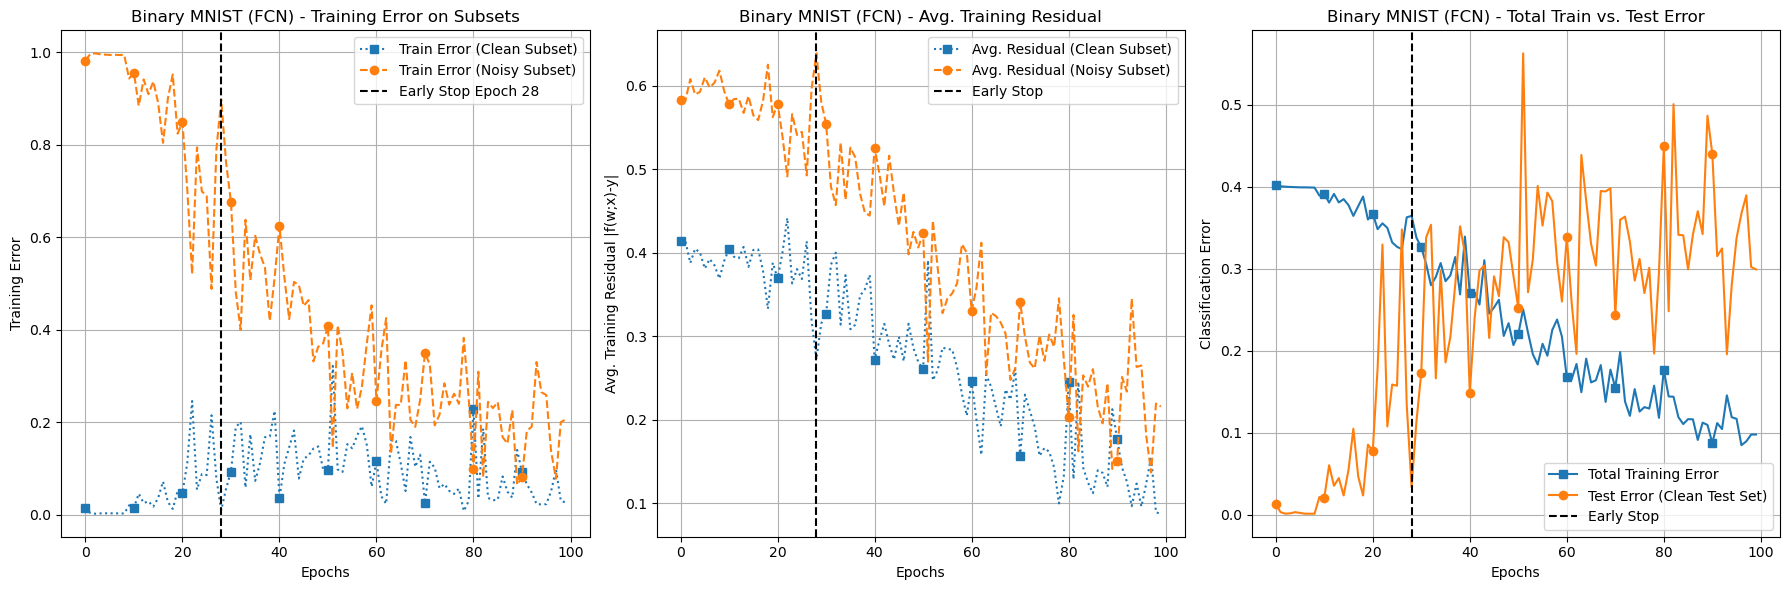

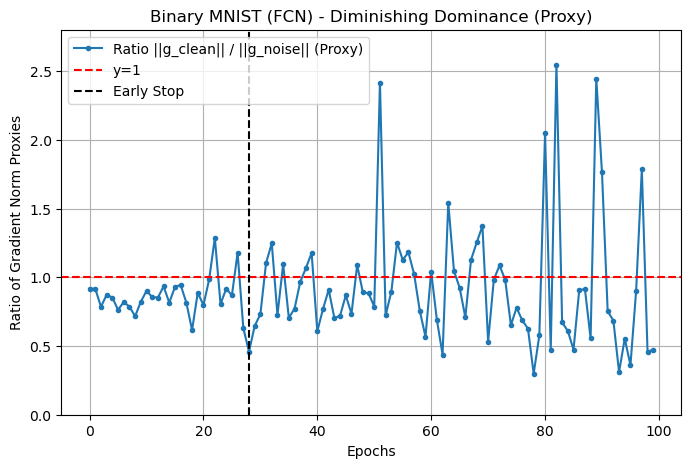

In [14]:
# --- Configuration for Experiment 1 ---
BINARY_CLASSES = [0, 1] # Example: '0' vs '1'
NOISE_LEVEL_BINARY = 0.4 # As in Fig 5 (noise level delta = 0.4)
NUM_EPOCHS_BINARY = 100 # Paper uses ~400 for Fig 5, adjust as needed for speed
BATCH_SIZE_BINARY = 256
LR_BINARY = 0.01 # Learning rate, adjust as needed
HIDDEN_DIMS_FCN = [512, 512] # For FCN (2 hidden layers)

# --- Data Loading ---
mnist_train_orig, mnist_test_orig, num_classes_in_binary_dataset = get_mnist_datasets(binary_classes=BINARY_CLASSES)
print(f"Binary classification: Using classes {BINARY_CLASSES}, remapped to 0 and 1.")
print(f"Original train samples: {len(mnist_train_orig)}, Original test samples: {len(mnist_test_orig)}")

# Add noise to training set
noisy_mnist_train_binary = NoisyDataset(mnist_train_orig, noise_level=NOISE_LEVEL_BINARY, num_classes=num_classes_in_binary_dataset, random_seed=SEED)
print(f"Noisy train samples: {len(noisy_mnist_train_binary)}. Noise level: {NOISE_LEVEL_BINARY}")
print(f"Actual noisy samples: {noisy_mnist_train_binary.is_noisy.sum().item()} out of {len(noisy_mnist_train_binary)}")

train_loader_binary = DataLoader(noisy_mnist_train_binary, batch_size=BATCH_SIZE_BINARY, shuffle=True)
test_loader_binary = DataLoader(mnist_test_orig, batch_size=BATCH_SIZE_BINARY, shuffle=False) # Test set is clean

# --- Model, Loss, Optimizer ---
input_dim_mnist = 28*28
# For binary classification with BCEWithLogitsLoss, model should output 1 logit
fcn_model_binary = FCN(input_dim=input_dim_mnist, hidden_dims=HIDDEN_DIMS_FCN, num_classes=1).to(DEVICE)

criterion_train_binary = nn.BCEWithLogitsLoss() 
criterion_eval_binary = nn.BCEWithLogitsLoss() 
optimizer_binary = optim.SGD(fcn_model_binary.parameters(), lr=LR_BINARY, momentum=0.9)

print("\nStarting Experiment 1: Binary MNIST Classification...")
history_binary = train_model(fcn_model_binary, 
                             train_loader_binary, 
                             test_loader_binary, 
                             criterion_train_binary, 
                             criterion_eval_binary, 
                             optimizer_binary, 
                             NUM_EPOCHS_BINARY, 
                             DEVICE,
                             num_classes_in_dataset=num_classes_in_binary_dataset)

plot_training_dynamics(history_binary, title_prefix="Binary MNIST (FCN) - ")

## 3. Experiment 2: Multi-class Classification

Following Section 5 of the paper, we'll use full MNIST (10 classes) with a CNN, or CIFAR-10 with a ResNet.

### 3.1 Multi-class MNIST with CNN

Multi-class MNIST: Using all 10 classes.
Original train samples: 60000, Original test samples: 10000
Noisy train samples: 60000. Noise level: 0.3
Actual noisy samples: 18000 out of 60000

Starting Experiment 2a: Multi-class MNIST Classification (CNN)...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/469
  Epoch 1/50, Batch 11/469
  Epoch 1/50, Batch 21/469
  Epoch 1/50, Batch 31/469
  Epoch 1/50, Batch 41/469
  Epoch 1/50, Batch 51/469
  Epoch 1/50, Batch 61/469
  Epoch 1/50, Batch 71/469
  Epoch 1/50, Batch 81/469
  Epoch 1/50, Batch 91/469
  Epoch 1/50, Batch 101/469
  Epoch 1/50, Batch 111/469
  Epoch 1/50, Batch 121/469
  Epoch 1/50, Batch 131/469
  Epoch 1/50, Batch 141/469
  Epoch 1/50, Batch 151/469
  Epoch 1/50, Batch 161/469
  Epoch 1/50, Batch 171/469
  Epoch 1/50, Batch 181/469
  Epoch 1/50, Batch 191/469
  Epoch 1/50, Batch 201/469
  Epoch 1/50, Batch 211/469
  Epoch 1/50, Batch 221/469
  Epoch 1/50, Batch 231/469
  Epoch 1/50, Batch 241/469
  Epoch 1/50, Batch 251/469
  Epoch 1/50, Batch 261/469
  Epoch 1/50, Batch 271/469
  Epoch 1/50, Batch 281/469
  Epoch 1/50, Batch 291/469
  Epoch 1/50, Batch 301/469
  Epoch 1/50, Batch 311/469
  Epoch 1/50, Batch 321/469
  Epoch 1/50, Batch 331/469
  Epoch 1/50, Batch 341/469
  Epoch 1/50, Batch 351/469
  E

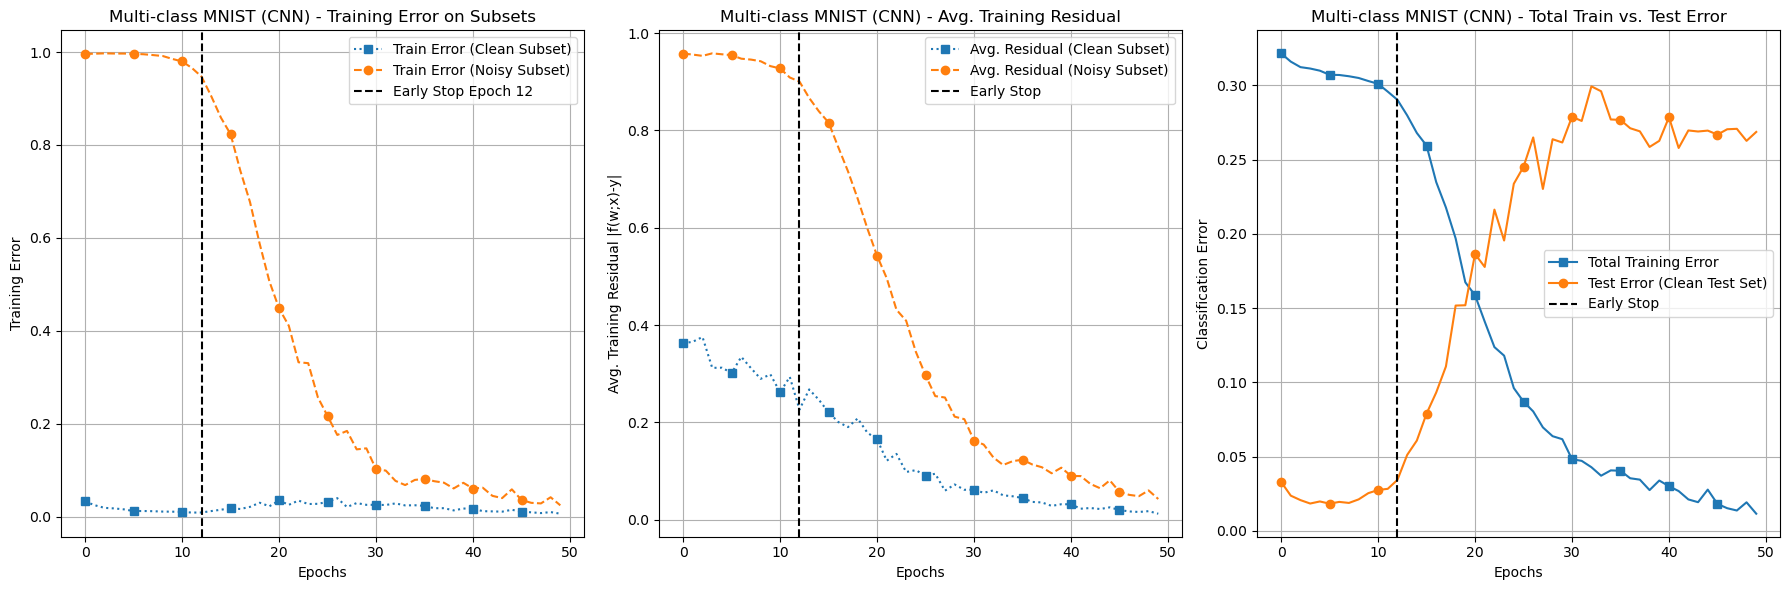

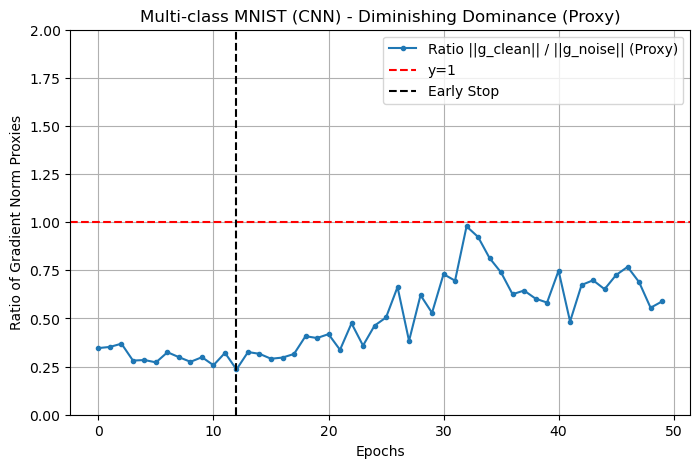

In [15]:
# --- Configuration for Experiment 2a (MNIST CNN) ---
NOISE_LEVEL_MNIST_MULTI = 0.3 # As in Fig 7, MNIST (delta=0.3)
NUM_EPOCHS_MNIST_MULTI = 50 # Paper uses ~180 for Fig 7, adjust for speed
BATCH_SIZE_MNIST_MULTI = 128 # Paper uses 512, adjust based on memory
LR_MNIST_MULTI = 0.01

# --- Data Loading ---
mnist_train_full_orig, mnist_test_full_orig, num_classes_mnist_multi = get_mnist_datasets()
print(f"Multi-class MNIST: Using all 10 classes.")
print(f"Original train samples: {len(mnist_train_full_orig)}, Original test samples: {len(mnist_test_full_orig)}")

noisy_mnist_train_multi = NoisyDataset(mnist_train_full_orig, noise_level=NOISE_LEVEL_MNIST_MULTI, num_classes=num_classes_mnist_multi, random_seed=SEED)
print(f"Noisy train samples: {len(noisy_mnist_train_multi)}. Noise level: {NOISE_LEVEL_MNIST_MULTI}")
print(f"Actual noisy samples: {noisy_mnist_train_multi.is_noisy.sum().item()} out of {len(noisy_mnist_train_multi)}")

train_loader_mnist_multi = DataLoader(noisy_mnist_train_multi, batch_size=BATCH_SIZE_MNIST_MULTI, shuffle=True)
test_loader_mnist_multi = DataLoader(mnist_test_full_orig, batch_size=BATCH_SIZE_MNIST_MULTI, shuffle=False)

# --- Model, Loss, Optimizer ---
cnn_model_mnist = CNN_MNIST(num_classes=num_classes_mnist_multi).to(DEVICE)

criterion_train_multi = nn.CrossEntropyLoss() 
criterion_eval_multi = nn.CrossEntropyLoss() 
optimizer_mnist_multi = optim.SGD(cnn_model_mnist.parameters(), lr=LR_MNIST_MULTI, momentum=0.9)

print("\nStarting Experiment 2a: Multi-class MNIST Classification (CNN)...")
history_mnist_multi = train_model(cnn_model_mnist, 
                                  train_loader_mnist_multi, 
                                  test_loader_mnist_multi, 
                                  criterion_train_multi, 
                                  criterion_eval_multi, 
                                  optimizer_mnist_multi, 
                                  NUM_EPOCHS_MNIST_MULTI, 
                                  DEVICE,
                                  num_classes_in_dataset=num_classes_mnist_multi)

plot_training_dynamics(history_mnist_multi, title_prefix="Multi-class MNIST (CNN) - ")

### 3.2 Multi-class CIFAR-10 with ResNet-9 (Simplified)

Files already downloaded and verified
Files already downloaded and verified
Multi-class CIFAR-10: Using all 10 classes.
Original train samples: 50000, Original test samples: 10000
Noisy train samples: 50000. Noise level: 0.4
Actual noisy samples: 20000 out of 50000

Starting Experiment 2b: Multi-class CIFAR-10 Classification (ResNet-9)...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  Epoch 1/5, Batch 1/1563
  Epoch 1/5, Batch 11/1563
  Epoch 1/5, Batch 21/1563
  Epoch 1/5, Batch 31/1563
  Epoch 1/5, Batch 41/1563
  Epoch 1/5, Batch 51/1563
  Epoch 1/5, Batch 61/1563
  Epoch 1/5, Batch 71/1563
  Epoch 1/5, Batch 81/1563
  Epoch 1/5, Batch 91/1563
  Epoch 1/5, Batch 101/1563
  Epoch 1/5, Batch 111/1563
  Epoch 1/5, Batch 121/1563
  Epoch 1/5, Batch 131/1563
  Epoch 1/5, Batch 141/1563
  Epoch 1/5, Batch 151/1563
  Epoch 1/5, Batch 161/1563
  Epoch 1/5, Batch 171/1563
  Epoch 1/5, Batch 181/1563
  Epoch 1/5, Batch 191/1563
  Epoch 1/5, Batch 201/1563
  Epoch 1/5, Batch 211/1563
  Epoch 1/5, Batch 221/1563
  Epoch 1/5, Batch 231/1563
  Epoch 1/5, Batch 241/1563
  Epoch 1/5, Batch 251/1563
  Epoch 1/5, Batch 261/1563
  Epoch 1/5, Batch 271/1563
  Epoch 1/5, Batch 281/1563
  Epoch 1/5, Batch 291/1563
  Epoch 1/5, Batch 301/1563
  Epoch 1/5, Batch 311/1563
  Epoch 1/5, Batch 321/1563
  Epoch 1/5, Batch 331/1563
  Epoch 1/5, Batch 341/1563
  Epoch 1/5, Batch 351/1563
  E

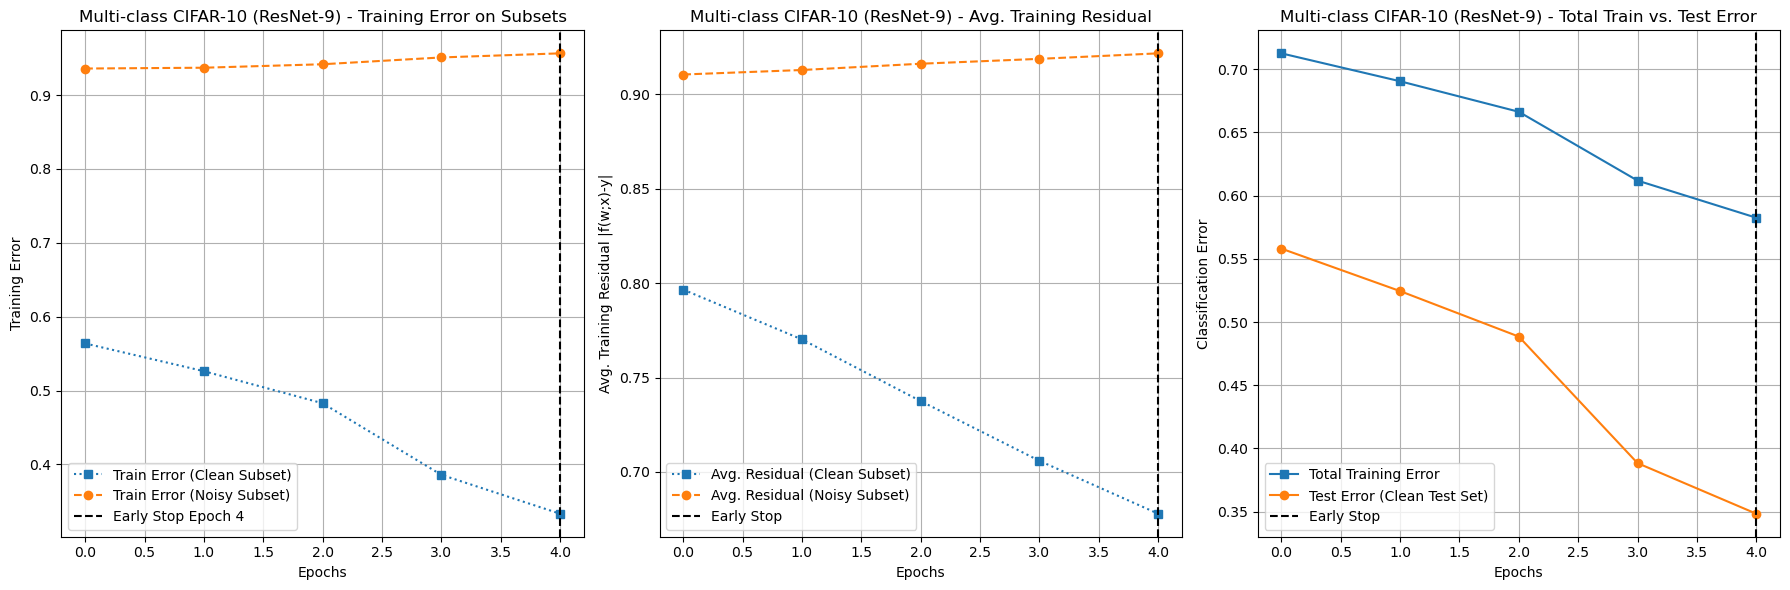

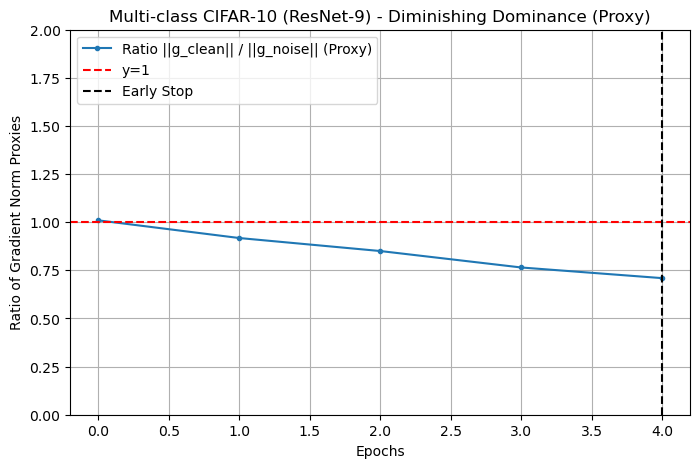

In [16]:
# --- Configuration for Experiment 2b (CIFAR-10 ResNet) ---
NOISE_LEVEL_CIFAR10 = 0.4 # As in Fig 7, CIFAR-10 (delta=0.4)
# MODIFIED: Reduced epochs for faster testing
NUM_EPOCHS_CIFAR10 = 5 # Paper uses ~300 for Fig 7, adjust for speed, START WITH A VERY LOW NUMBER
# MODIFIED: Reduced batch size for faster testing, especially on CPU
BATCH_SIZE_CIFAR10 = 32 # Paper uses 512, adjust based on memory/CPU speed
LR_CIFAR10 = 0.01 # May need tuning, or a scheduler

# --- Data Loading ---
cifar10_train_orig, cifar10_test_orig, num_classes_cifar10 = get_cifar10_datasets()
print(f"Multi-class CIFAR-10: Using all 10 classes.")
print(f"Original train samples: {len(cifar10_train_orig)}, Original test samples: {len(cifar10_test_orig)}")

noisy_cifar10_train = NoisyDataset(cifar10_train_orig, noise_level=NOISE_LEVEL_CIFAR10, num_classes=num_classes_cifar10, random_seed=SEED)
print(f"Noisy train samples: {len(noisy_cifar10_train)}. Noise level: {NOISE_LEVEL_CIFAR10}")
print(f"Actual noisy samples: {noisy_cifar10_train.is_noisy.sum().item()} out of {len(noisy_cifar10_train)}")

# Using num_workers=0 as in your provided snippet
train_loader_cifar10 = DataLoader(noisy_cifar10_train, batch_size=BATCH_SIZE_CIFAR10, shuffle=True, num_workers=0)
test_loader_cifar10 = DataLoader(cifar10_test_orig, batch_size=BATCH_SIZE_CIFAR10, shuffle=False, num_workers=0)

# --- Model, Loss, Optimizer ---
resnet_model_cifar10 = ResNet9_CIFAR(num_blocks=[1,1,1,1], num_classes=num_classes_cifar10).to(DEVICE)

criterion_train_cifar10 = nn.CrossEntropyLoss()
criterion_eval_cifar10 = nn.CrossEntropyLoss()
optimizer_cifar10 = optim.SGD(resnet_model_cifar10.parameters(), lr=LR_CIFAR10, momentum=0.9, weight_decay=5e-4)
# Scheduler T_max should match the number of epochs
scheduler_cifar10 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_cifar10, T_max=NUM_EPOCHS_CIFAR10)

print("\nStarting Experiment 2b: Multi-class CIFAR-10 Classification (ResNet-9)...")
history_cifar10 = train_model(resnet_model_cifar10,
                              train_loader_cifar10,
                              test_loader_cifar10,
                              criterion_train_cifar10,
                              criterion_eval_cifar10,
                              optimizer_cifar10,
                              NUM_EPOCHS_CIFAR10,
                              DEVICE,
                              num_classes_in_dataset=num_classes_cifar10,
                              scheduler=scheduler_cifar10)

plot_training_dynamics(history_cifar10, title_prefix="Multi-class CIFAR-10 (ResNet-9) - ")

## 4. Experiment 3: Effect of Network Width (Appendix C.3)

We can re-run the binary MNIST experiment with varying FCN hidden layer widths.


Starting Experiment 3: Effect of Network Width...

--- Testing FCN with hidden_dims = [32, 32] ---


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/50
  Epoch 1/50, Batch 11/50
  Epoch 1/50, Batch 21/50
  Epoch 1/50, Batch 31/50
  Epoch 1/50, Batch 41/50
  Epoch 1/50, Batch 50/50
Epoch 1/50 - Train Loss: 0.6738, Train Acc: 0.5994, Test Loss: 0.5276, Test Acc: 0.9953
  Clean_L: 0.5288, Noisy_L: 0.8914, Clean_Res: 0.4100, Noisy_Res: 0.5890
  Proxy ||g_clean||: 4018.24, Proxy ||g_noise||: 4515.65, Ratio: 0.89
  Epoch 2/50, Batch 1/50
  Epoch 2/50, Batch 11/50
  Epoch 2/50, Batch 21/50
  Epoch 2/50, Batch 31/50
  Epoch 2/50, Batch 41/50
  Epoch 2/50, Batch 50/50
Epoch 2/50 - Train Loss: 0.6728, Train Acc: 0.5997, Test Loss: 0.5198, Test Acc: 0.9991
  Clean_L: 0.5204, Noisy_L: 0.9014, Clean_Res: 0.4052, Noisy_Res: 0.5932
  Proxy ||g_clean||: 3954.88, Proxy ||g_noise||: 4566.47, Ratio: 0.87
  Epoch 3/50, Batch 1/50
  Epoch 3/50, Batch 11/50
  Epoch 3/50, Batch 21/50
  Epoch 3/50, Batch 31/50
  Epoch 3/50, Batch 41/50
  Epoch 3/50, Batch 50/50
Epoch 3/50 - Train Loss: 0.6723, Train Acc: 0.5998, Test Loss: 0.5100, Te

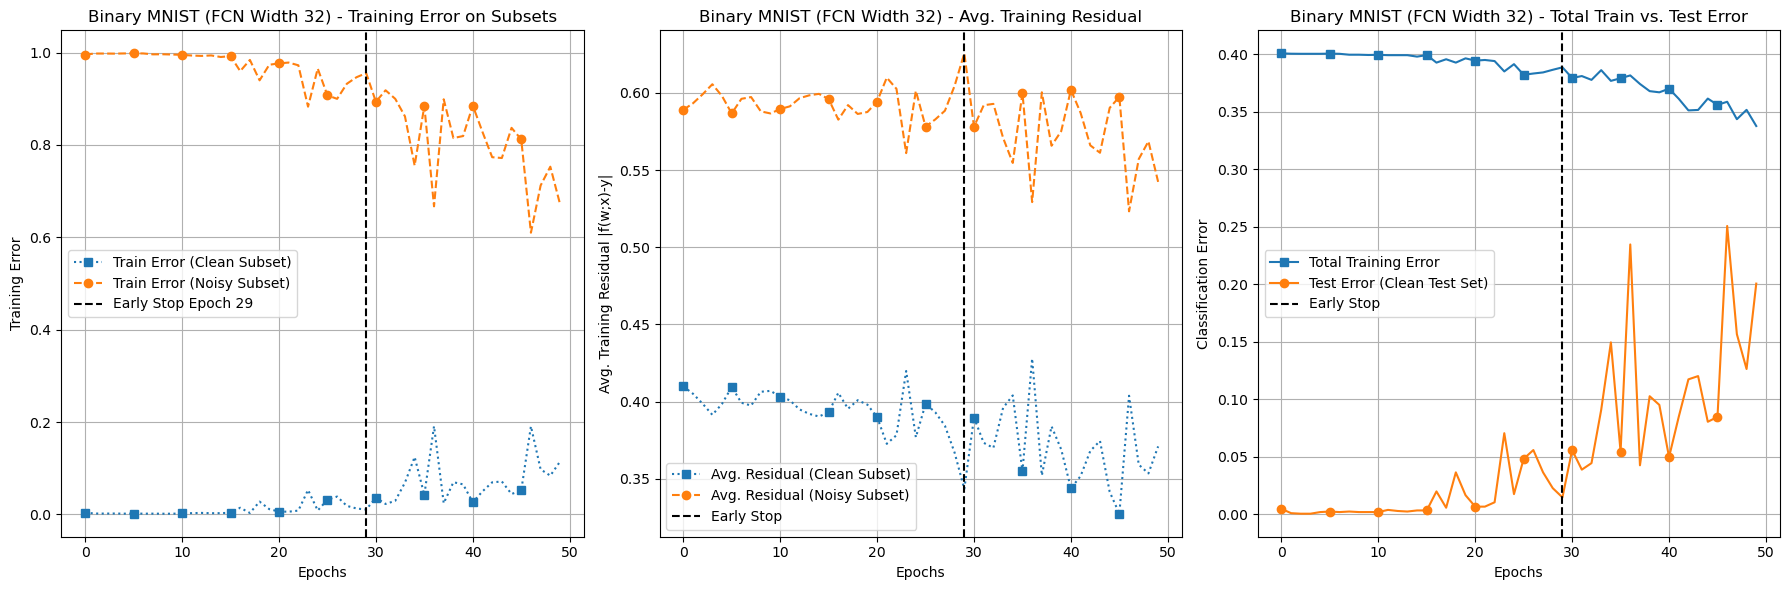

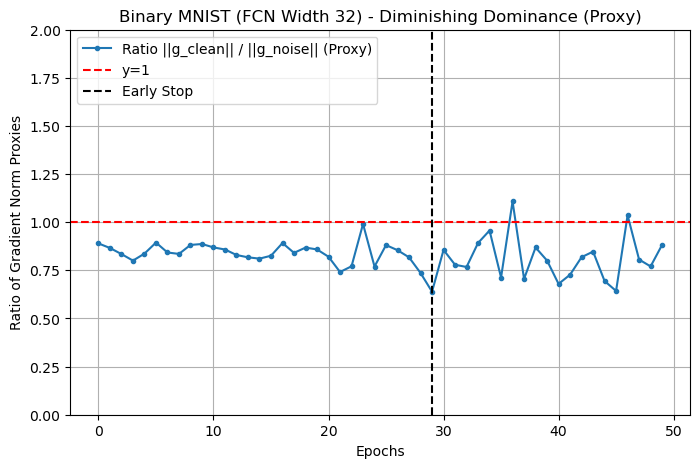


--- Testing FCN with hidden_dims = [128, 128] ---


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/50
  Epoch 1/50, Batch 11/50
  Epoch 1/50, Batch 21/50
  Epoch 1/50, Batch 31/50
  Epoch 1/50, Batch 41/50
  Epoch 1/50, Batch 50/50
Epoch 1/50 - Train Loss: 0.6737, Train Acc: 0.5970, Test Loss: 0.5260, Test Acc: 0.9915
  Clean_L: 0.5281, Noisy_L: 0.8921, Clean_Res: 0.4095, Noisy_Res: 0.5892
  Proxy ||g_clean||: 4013.40, Proxy ||g_noise||: 4519.59, Ratio: 0.89
  Epoch 2/50, Batch 1/50
  Epoch 2/50, Batch 11/50
  Epoch 2/50, Batch 21/50
  Epoch 2/50, Batch 31/50
  Epoch 2/50, Batch 41/50
  Epoch 2/50, Batch 50/50
Epoch 2/50 - Train Loss: 0.6725, Train Acc: 0.5992, Test Loss: 0.5138, Test Acc: 0.9939
  Clean_L: 0.5154, Noisy_L: 0.9082, Clean_Res: 0.4019, Noisy_Res: 0.5956
  Proxy ||g_clean||: 3916.77, Proxy ||g_noise||: 4600.86, Ratio: 0.85
  Epoch 3/50, Batch 1/50
  Epoch 3/50, Batch 11/50
  Epoch 3/50, Batch 21/50
  Epoch 3/50, Batch 31/50
  Epoch 3/50, Batch 41/50
  Epoch 3/50, Batch 50/50
Epoch 3/50 - Train Loss: 0.6718, Train Acc: 0.5994, Test Loss: 0.5325, Te

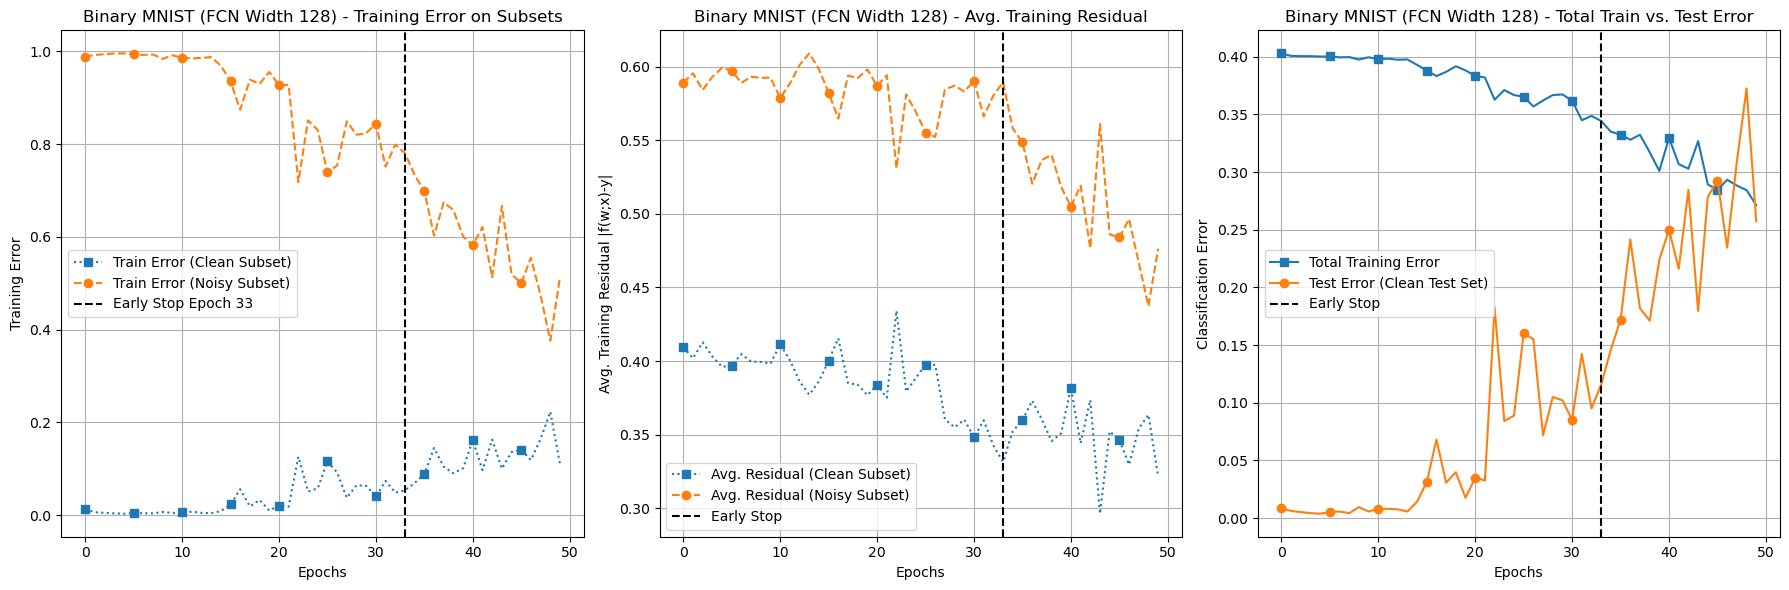

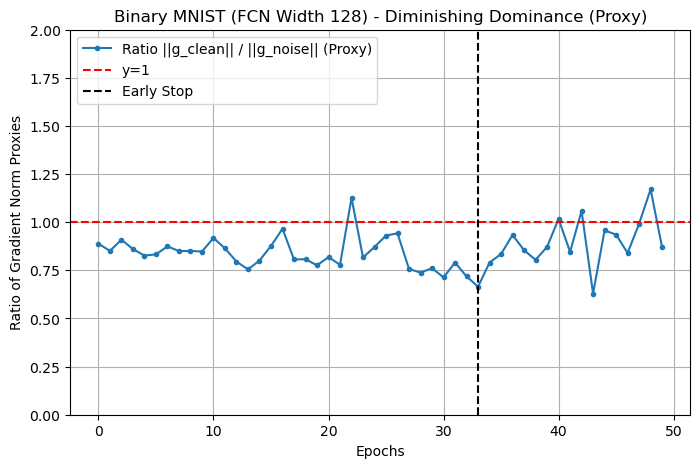


--- Testing FCN with hidden_dims = [512, 512] ---


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/50
  Epoch 1/50, Batch 11/50
  Epoch 1/50, Batch 21/50
  Epoch 1/50, Batch 31/50
  Epoch 1/50, Batch 41/50
  Epoch 1/50, Batch 50/50
Epoch 1/50 - Train Loss: 0.6727, Train Acc: 0.5997, Test Loss: 0.5130, Test Acc: 0.9957
  Clean_L: 0.5140, Noisy_L: 0.9108, Clean_Res: 0.4010, Noisy_Res: 0.5965
  Proxy ||g_clean||: 3905.62, Proxy ||g_noise||: 4614.32, Ratio: 0.85
  Epoch 2/50, Batch 1/50
  Epoch 2/50, Batch 11/50
  Epoch 2/50, Batch 21/50
  Epoch 2/50, Batch 31/50
  Epoch 2/50, Batch 41/50
  Epoch 2/50, Batch 50/50
Epoch 2/50 - Train Loss: 0.6712, Train Acc: 0.5996, Test Loss: 0.5023, Test Acc: 0.9972
  Clean_L: 0.5024, Noisy_L: 0.9243, Clean_Res: 0.3940, Noisy_Res: 0.6018
  Proxy ||g_clean||: 3817.66, Proxy ||g_noise||: 4682.51, Ratio: 0.82
  Epoch 3/50, Batch 1/50
  Epoch 3/50, Batch 11/50
  Epoch 3/50, Batch 21/50
  Epoch 3/50, Batch 31/50
  Epoch 3/50, Batch 41/50
  Epoch 3/50, Batch 50/50
Epoch 3/50 - Train Loss: 0.6698, Train Acc: 0.6002, Test Loss: 0.5163, Te

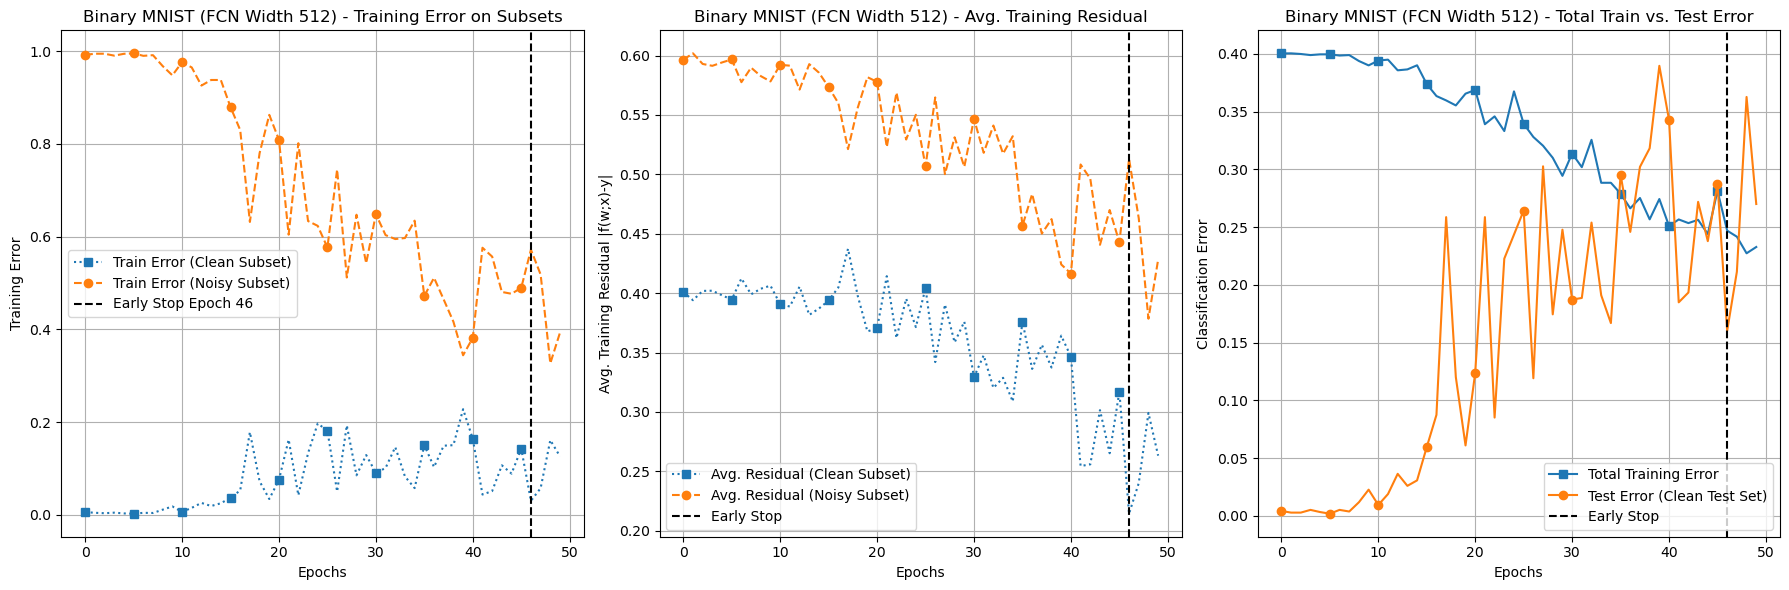

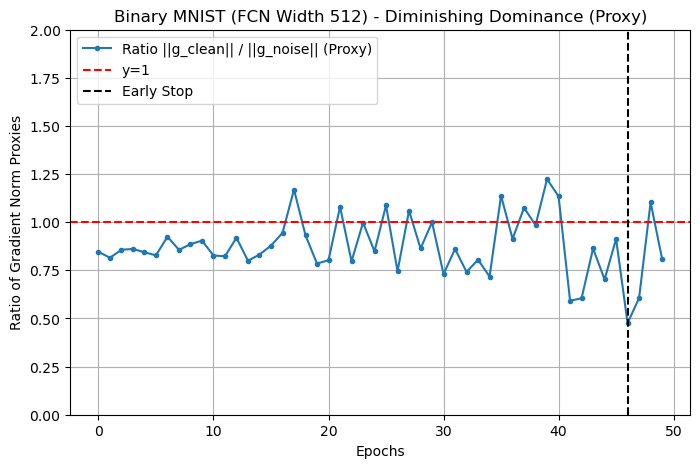


--- Testing FCN with hidden_dims = [2048, 2048] ---


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/50
  Epoch 1/50, Batch 11/50
  Epoch 1/50, Batch 21/50
  Epoch 1/50, Batch 31/50
  Epoch 1/50, Batch 41/50
  Epoch 1/50, Batch 50/50
Epoch 1/50 - Train Loss: 0.6725, Train Acc: 0.5998, Test Loss: 0.4790, Test Acc: 0.9976
  Clean_L: 0.4792, Noisy_L: 0.9624, Clean_Res: 0.3797, Noisy_Res: 0.6163
  Proxy ||g_clean||: 3641.47, Proxy ||g_noise||: 4875.28, Ratio: 0.75
  Epoch 2/50, Batch 1/50
  Epoch 2/50, Batch 11/50
  Epoch 2/50, Batch 21/50
  Epoch 2/50, Batch 31/50
  Epoch 2/50, Batch 41/50
  Epoch 2/50, Batch 50/50
Epoch 2/50 - Train Loss: 0.6687, Train Acc: 0.6006, Test Loss: 0.5058, Test Acc: 0.9986
  Clean_L: 0.5035, Noisy_L: 0.9166, Clean_Res: 0.3946, Noisy_Res: 0.5987
  Proxy ||g_clean||: 3825.74, Proxy ||g_noise||: 4643.30, Ratio: 0.82
  Epoch 3/50, Batch 1/50
  Epoch 3/50, Batch 11/50
  Epoch 3/50, Batch 21/50
  Epoch 3/50, Batch 31/50
  Epoch 3/50, Batch 41/50
  Epoch 3/50, Batch 50/50
Epoch 3/50 - Train Loss: 0.6696, Train Acc: 0.6001, Test Loss: 0.4848, Te

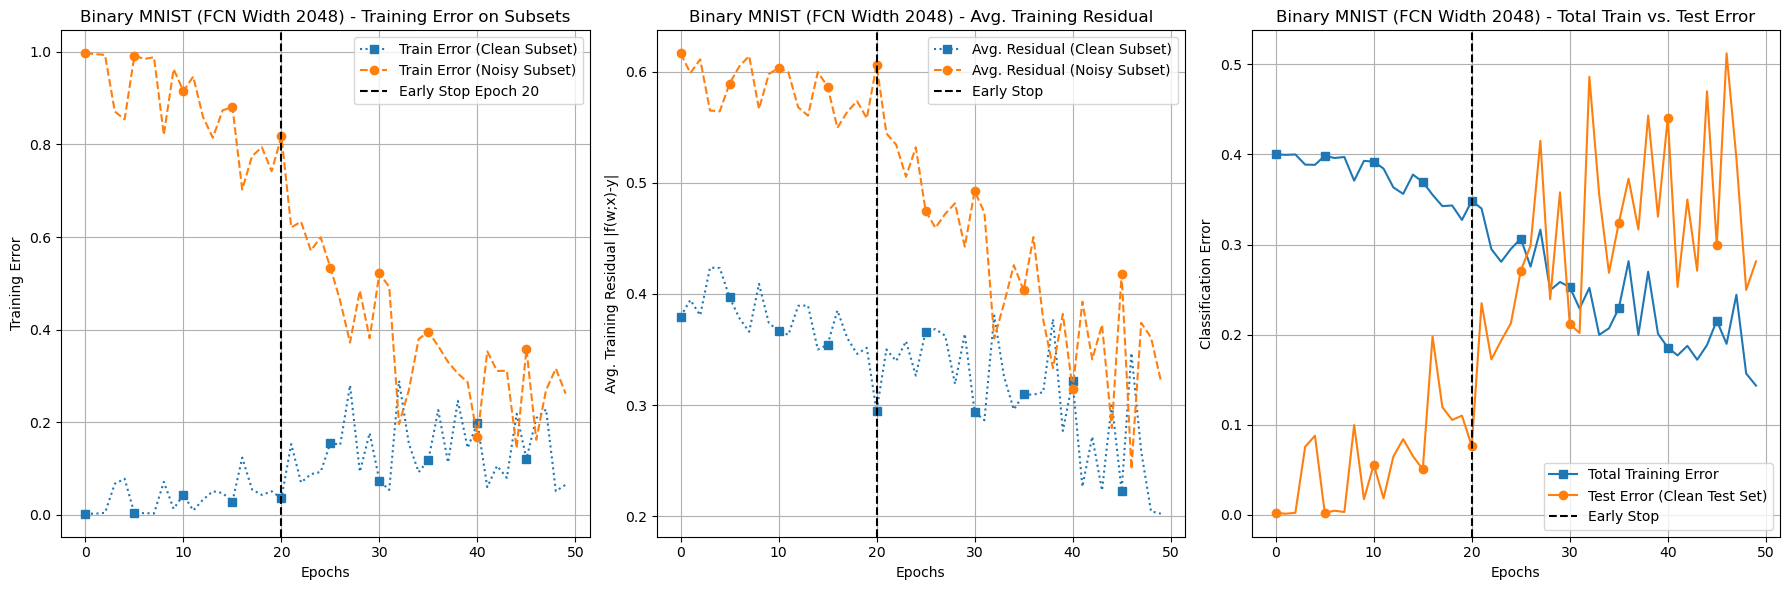

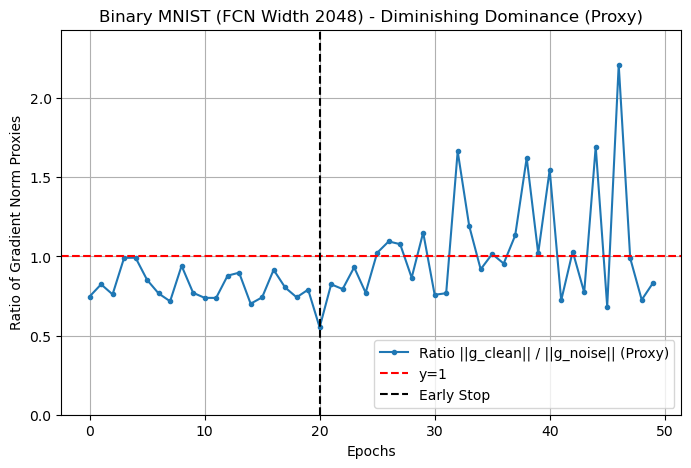


Experiment 3 (Width Test) Complete. Histories stored in 'histories_by_width'.


In [17]:
WIDTHS_TO_TEST = [32, 128, 512, 2048] # From Fig 12 in paper
NUM_EPOCHS_WIDTH_TEST = 50 # Reduced epochs for faster testing
NOISE_LEVEL_WIDTH_TEST = 0.4 # As in Fig 12

histories_by_width = {}

print("\nStarting Experiment 3: Effect of Network Width...")
for width in WIDTHS_TO_TEST:
    print(f"\n--- Testing FCN with hidden_dims = [{width}, {width}] ---")
    mnist_train_orig_w, mnist_test_orig_w, num_classes_w_dataset = get_mnist_datasets(binary_classes=BINARY_CLASSES)
    noisy_mnist_train_w = NoisyDataset(mnist_train_orig_w, noise_level=NOISE_LEVEL_WIDTH_TEST, num_classes=num_classes_w_dataset, random_seed=SEED)
    train_loader_w = DataLoader(noisy_mnist_train_w, batch_size=BATCH_SIZE_BINARY, shuffle=True)
    test_loader_w = DataLoader(mnist_test_orig_w, batch_size=BATCH_SIZE_BINARY, shuffle=False)

    fcn_model_w = FCN(input_dim=input_dim_mnist, hidden_dims=[width, width], num_classes=1).to(DEVICE) # Binary output is 1 logit
    optimizer_w = optim.SGD(fcn_model_w.parameters(), lr=LR_BINARY, momentum=0.9)

    history_w = train_model(fcn_model_w, train_loader_w, test_loader_w, 
                            criterion_train_binary, criterion_eval_binary, 
                            optimizer_w, NUM_EPOCHS_WIDTH_TEST, DEVICE, num_classes_in_dataset=num_classes_w_dataset)
    histories_by_width[width] = history_w
    plot_training_dynamics(history_w, title_prefix=f"Binary MNIST (FCN Width {width}) - ")

print("\nExperiment 3 (Width Test) Complete. Histories stored in 'histories_by_width'.")

## 5. Experiment 4: Effect of Noise Level (Appendix C.4)

We can re-run the multi-class MNIST experiment with varying noise levels.


Starting Experiment 4: Effect of Noise Level...

--- Testing Multi-class MNIST with Noise Level = 0.1 ---


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/469
  Epoch 1/50, Batch 11/469
  Epoch 1/50, Batch 21/469
  Epoch 1/50, Batch 31/469
  Epoch 1/50, Batch 41/469
  Epoch 1/50, Batch 51/469
  Epoch 1/50, Batch 61/469
  Epoch 1/50, Batch 71/469
  Epoch 1/50, Batch 81/469
  Epoch 1/50, Batch 91/469
  Epoch 1/50, Batch 101/469
  Epoch 1/50, Batch 111/469
  Epoch 1/50, Batch 121/469
  Epoch 1/50, Batch 131/469
  Epoch 1/50, Batch 141/469
  Epoch 1/50, Batch 151/469
  Epoch 1/50, Batch 161/469
  Epoch 1/50, Batch 171/469
  Epoch 1/50, Batch 181/469
  Epoch 1/50, Batch 191/469
  Epoch 1/50, Batch 201/469
  Epoch 1/50, Batch 211/469
  Epoch 1/50, Batch 221/469
  Epoch 1/50, Batch 231/469
  Epoch 1/50, Batch 241/469
  Epoch 1/50, Batch 251/469
  Epoch 1/50, Batch 261/469
  Epoch 1/50, Batch 271/469
  Epoch 1/50, Batch 281/469
  Epoch 1/50, Batch 291/469
  Epoch 1/50, Batch 301/469
  Epoch 1/50, Batch 311/469
  Epoch 1/50, Batch 321/469
  Epoch 1/50, Batch 331/469
  Epoch 1/50, Batch 341/469
  Epoch 1/50, Batch 351/469
  E

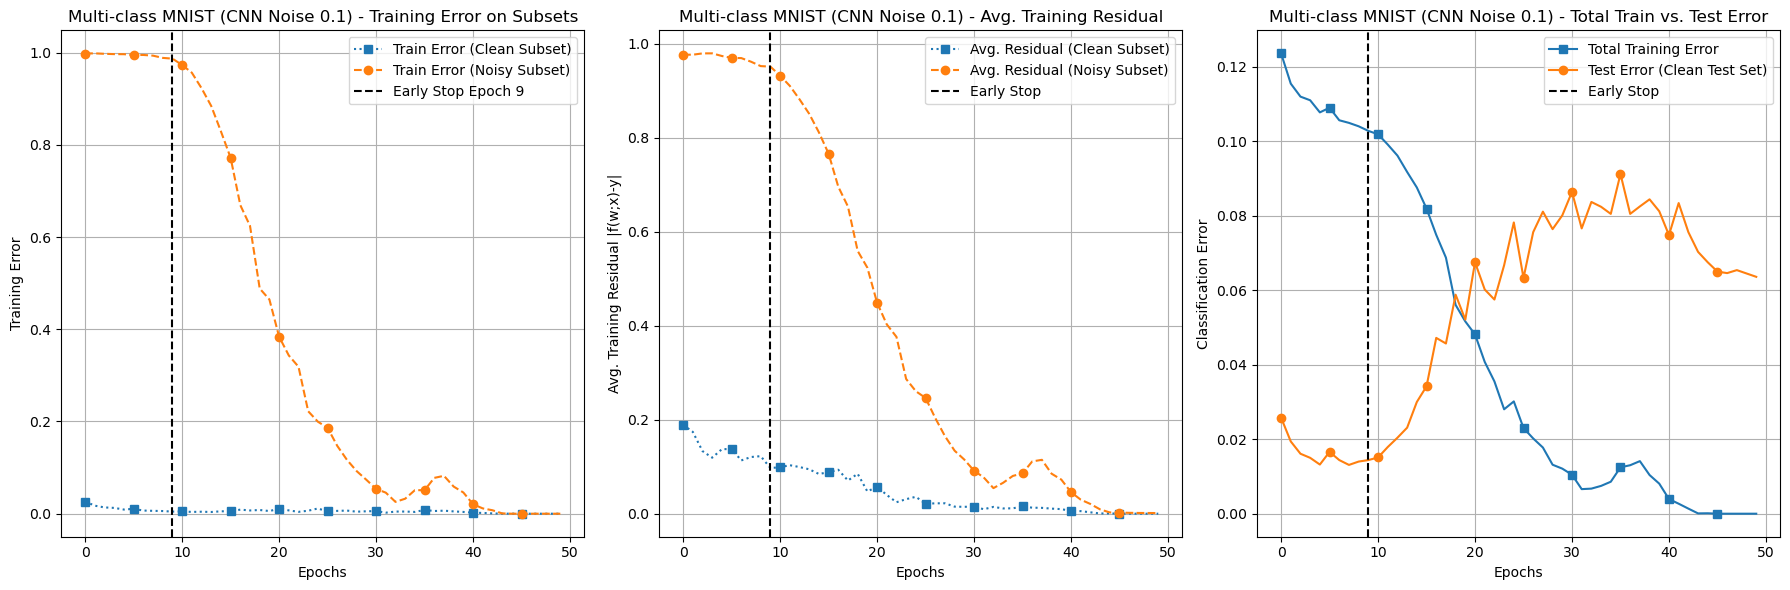

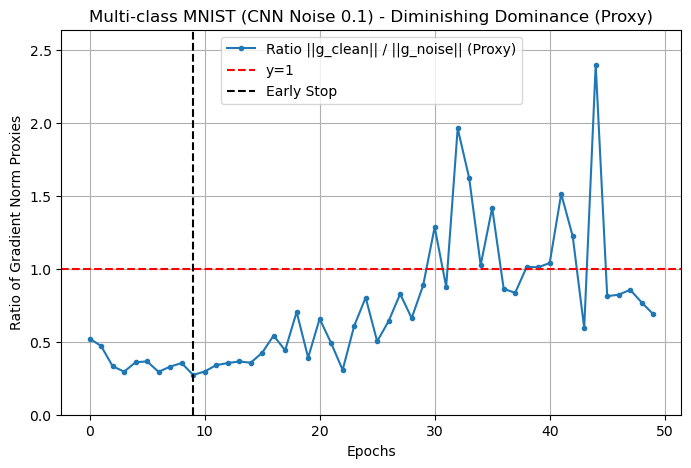


--- Testing Multi-class MNIST with Noise Level = 0.2 ---


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/469
  Epoch 1/50, Batch 11/469
  Epoch 1/50, Batch 21/469
  Epoch 1/50, Batch 31/469
  Epoch 1/50, Batch 41/469
  Epoch 1/50, Batch 51/469
  Epoch 1/50, Batch 61/469
  Epoch 1/50, Batch 71/469
  Epoch 1/50, Batch 81/469
  Epoch 1/50, Batch 91/469
  Epoch 1/50, Batch 101/469
  Epoch 1/50, Batch 111/469
  Epoch 1/50, Batch 121/469
  Epoch 1/50, Batch 131/469
  Epoch 1/50, Batch 141/469
  Epoch 1/50, Batch 151/469
  Epoch 1/50, Batch 161/469
  Epoch 1/50, Batch 171/469
  Epoch 1/50, Batch 181/469
  Epoch 1/50, Batch 191/469
  Epoch 1/50, Batch 201/469
  Epoch 1/50, Batch 211/469
  Epoch 1/50, Batch 221/469
  Epoch 1/50, Batch 231/469
  Epoch 1/50, Batch 241/469
  Epoch 1/50, Batch 251/469
  Epoch 1/50, Batch 261/469
  Epoch 1/50, Batch 271/469
  Epoch 1/50, Batch 281/469
  Epoch 1/50, Batch 291/469
  Epoch 1/50, Batch 301/469
  Epoch 1/50, Batch 311/469
  Epoch 1/50, Batch 321/469
  Epoch 1/50, Batch 331/469
  Epoch 1/50, Batch 341/469
  Epoch 1/50, Batch 351/469
  E

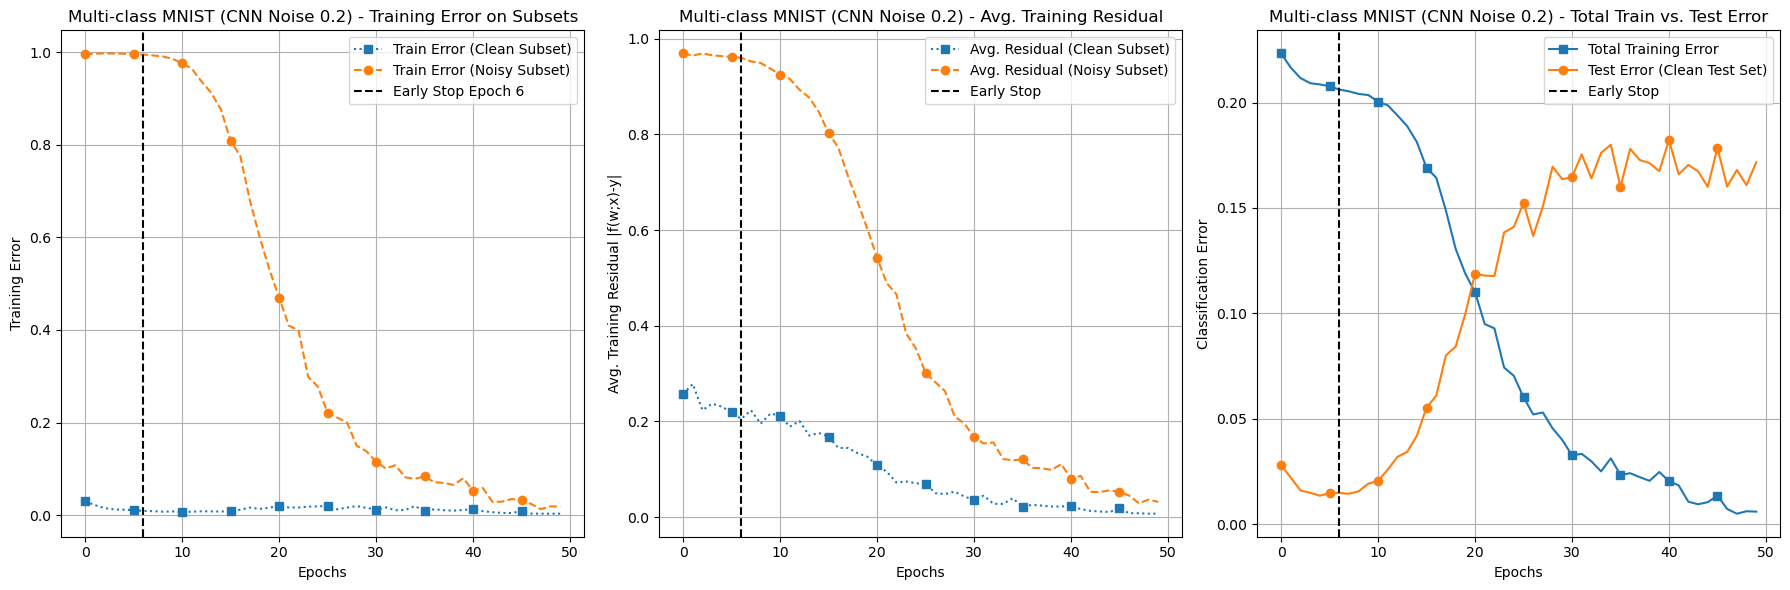

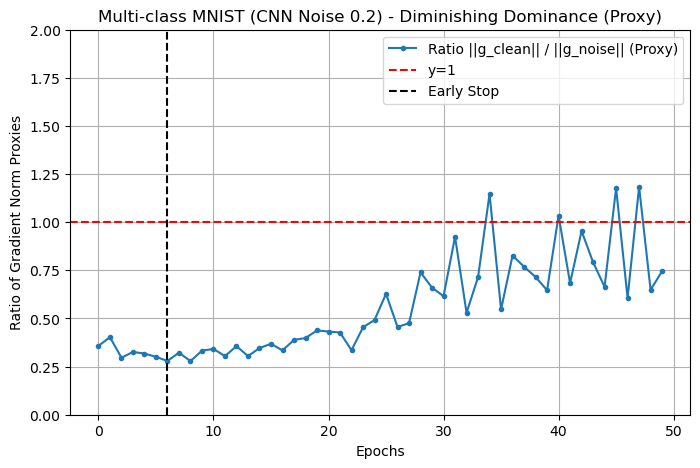


--- Testing Multi-class MNIST with Noise Level = 0.3 ---


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/469
  Epoch 1/50, Batch 11/469
  Epoch 1/50, Batch 21/469
  Epoch 1/50, Batch 31/469
  Epoch 1/50, Batch 41/469
  Epoch 1/50, Batch 51/469
  Epoch 1/50, Batch 61/469
  Epoch 1/50, Batch 71/469
  Epoch 1/50, Batch 81/469
  Epoch 1/50, Batch 91/469
  Epoch 1/50, Batch 101/469
  Epoch 1/50, Batch 111/469
  Epoch 1/50, Batch 121/469
  Epoch 1/50, Batch 131/469
  Epoch 1/50, Batch 141/469
  Epoch 1/50, Batch 151/469
  Epoch 1/50, Batch 161/469
  Epoch 1/50, Batch 171/469
  Epoch 1/50, Batch 181/469
  Epoch 1/50, Batch 191/469
  Epoch 1/50, Batch 201/469
  Epoch 1/50, Batch 211/469
  Epoch 1/50, Batch 221/469
  Epoch 1/50, Batch 231/469
  Epoch 1/50, Batch 241/469
  Epoch 1/50, Batch 251/469
  Epoch 1/50, Batch 261/469
  Epoch 1/50, Batch 271/469
  Epoch 1/50, Batch 281/469
  Epoch 1/50, Batch 291/469
  Epoch 1/50, Batch 301/469
  Epoch 1/50, Batch 311/469
  Epoch 1/50, Batch 321/469
  Epoch 1/50, Batch 331/469
  Epoch 1/50, Batch 341/469
  Epoch 1/50, Batch 351/469
  E

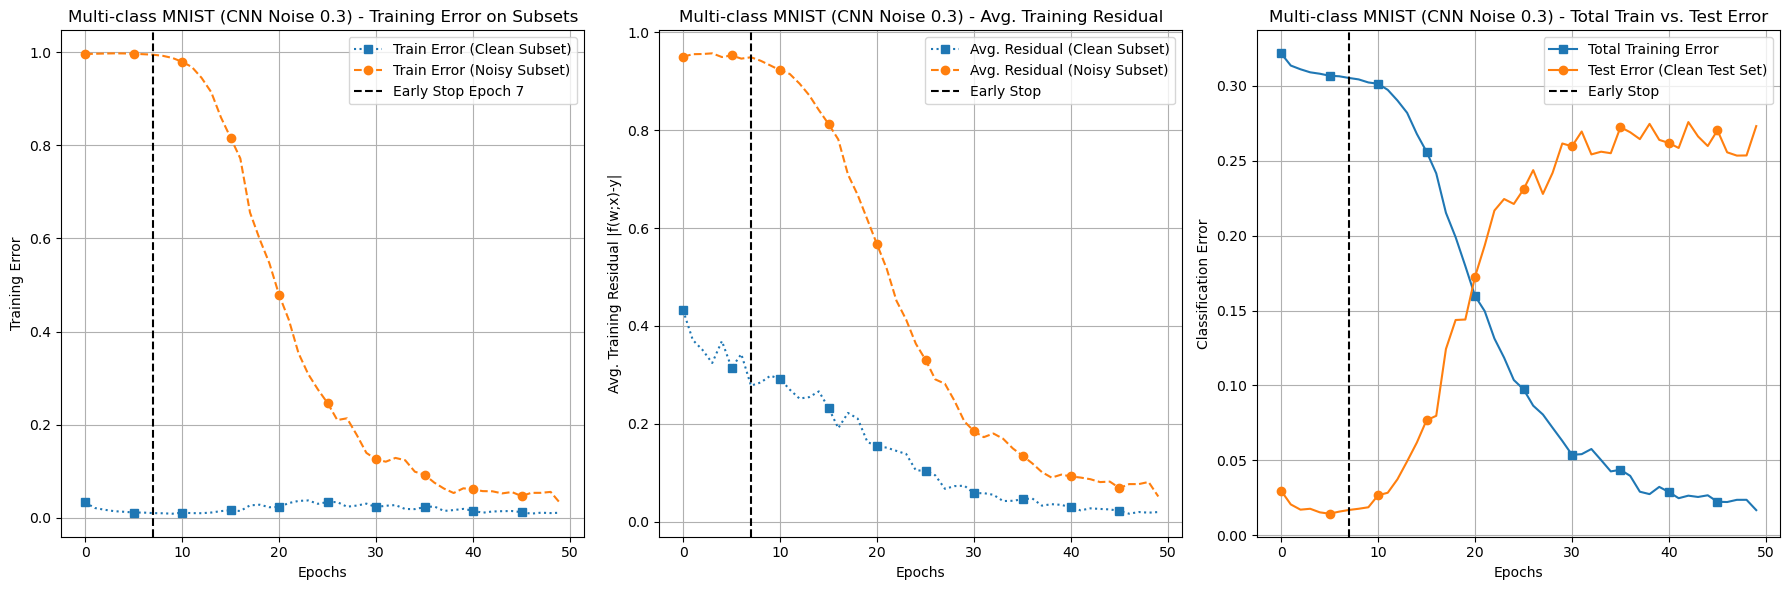

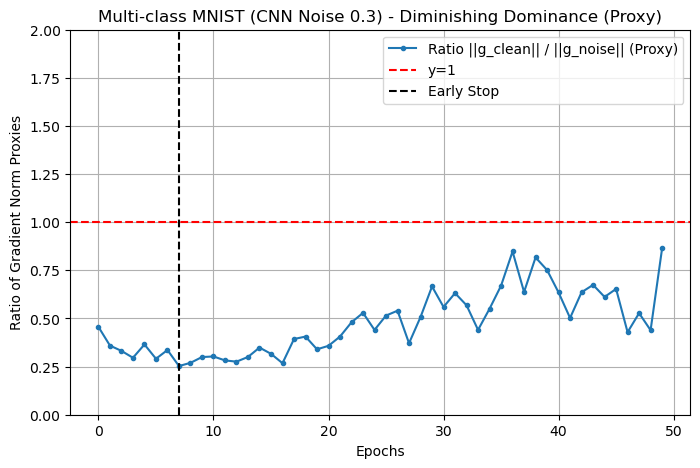


--- Testing Multi-class MNIST with Noise Level = 0.4 ---


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 1/50, Batch 1/469
  Epoch 1/50, Batch 11/469
  Epoch 1/50, Batch 21/469
  Epoch 1/50, Batch 31/469
  Epoch 1/50, Batch 41/469
  Epoch 1/50, Batch 51/469
  Epoch 1/50, Batch 61/469
  Epoch 1/50, Batch 71/469
  Epoch 1/50, Batch 81/469
  Epoch 1/50, Batch 91/469
  Epoch 1/50, Batch 101/469
  Epoch 1/50, Batch 111/469
  Epoch 1/50, Batch 121/469
  Epoch 1/50, Batch 131/469
  Epoch 1/50, Batch 141/469
  Epoch 1/50, Batch 151/469
  Epoch 1/50, Batch 161/469
  Epoch 1/50, Batch 171/469
  Epoch 1/50, Batch 181/469
  Epoch 1/50, Batch 191/469
  Epoch 1/50, Batch 201/469
  Epoch 1/50, Batch 211/469
  Epoch 1/50, Batch 221/469
  Epoch 1/50, Batch 231/469
  Epoch 1/50, Batch 241/469
  Epoch 1/50, Batch 251/469
  Epoch 1/50, Batch 261/469
  Epoch 1/50, Batch 271/469
  Epoch 1/50, Batch 281/469
  Epoch 1/50, Batch 291/469
  Epoch 1/50, Batch 301/469
  Epoch 1/50, Batch 311/469
  Epoch 1/50, Batch 321/469
  Epoch 1/50, Batch 331/469
  Epoch 1/50, Batch 341/469
  Epoch 1/50, Batch 351/469
  E

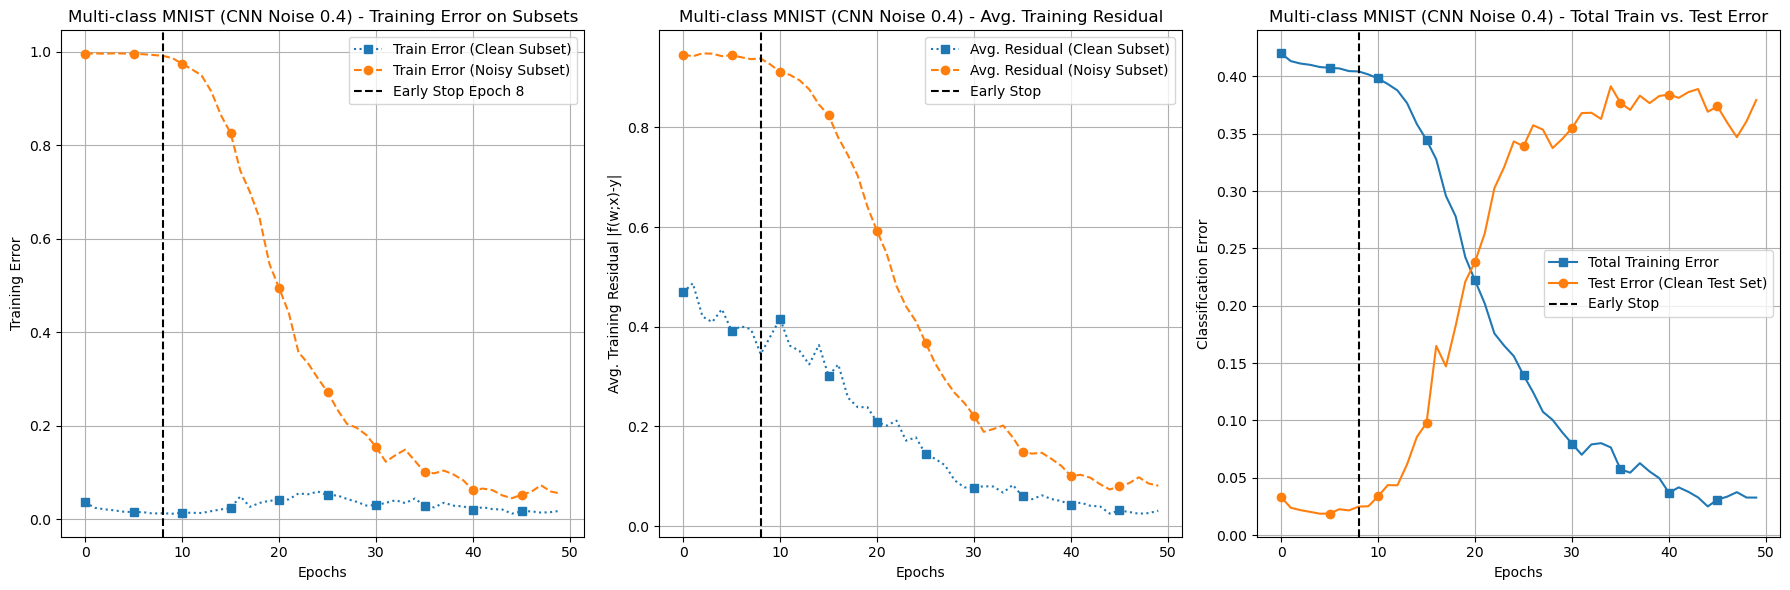

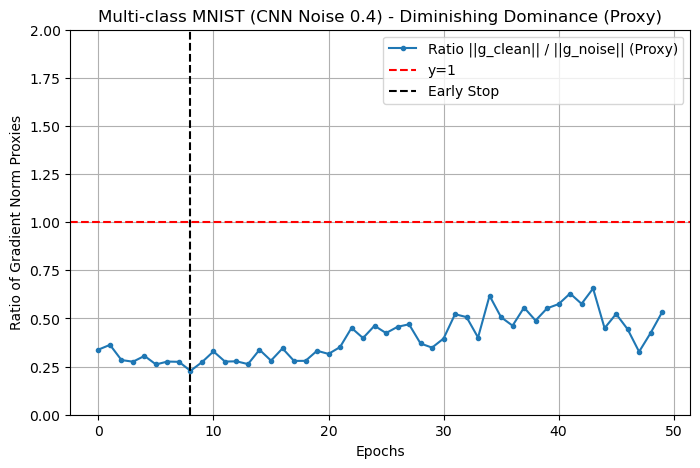


Experiment 4 (Noise Level Test) Complete. Histories stored in 'histories_by_noise_level'.


In [18]:
NOISE_LEVELS_TO_TEST = [0.1, 0.2, 0.3, 0.4] # From Fig 13 in paper
NUM_EPOCHS_NOISE_TEST = 50 # Reduced epochs

histories_by_noise_level = {}

print("\nStarting Experiment 4: Effect of Noise Level...")
for noise_lvl in NOISE_LEVELS_TO_TEST:
    print(f"\n--- Testing Multi-class MNIST with Noise Level = {noise_lvl} ---")
    mnist_train_full_orig_nl, mnist_test_full_orig_nl, num_classes_nl_dataset = get_mnist_datasets()
    noisy_mnist_train_nl = NoisyDataset(mnist_train_full_orig_nl, noise_level=noise_lvl, num_classes=num_classes_nl_dataset, random_seed=SEED)
    train_loader_nl = DataLoader(noisy_mnist_train_nl, batch_size=BATCH_SIZE_MNIST_MULTI, shuffle=True)
    test_loader_nl = DataLoader(mnist_test_full_orig_nl, batch_size=BATCH_SIZE_MNIST_MULTI, shuffle=False)

    cnn_model_nl = CNN_MNIST(num_classes=num_classes_nl_dataset).to(DEVICE) 
    optimizer_nl = optim.SGD(cnn_model_nl.parameters(), lr=LR_MNIST_MULTI, momentum=0.9)

    history_nl = train_model(cnn_model_nl, train_loader_nl, test_loader_nl, 
                             criterion_train_multi, criterion_eval_multi, 
                             optimizer_nl, NUM_EPOCHS_NOISE_TEST, DEVICE, num_classes_in_dataset=num_classes_nl_dataset)
    histories_by_noise_level[noise_lvl] = history_nl
    plot_training_dynamics(history_nl, title_prefix=f"Multi-class MNIST (CNN Noise {noise_lvl}) - ")

print("\nExperiment 4 (Noise Level Test) Complete. Histories stored in 'histories_by_noise_level'.")